# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [44]:
# Add any additional import statements you need here
import matplotlib.pyplot as plt
import seaborn as sns


In [25]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [20]:
# Read in the lyrics data
# Construct the full path to the lyrics folder

# Iterate over the artists' folders
# Define the subfolder paths
lyrics_folder = "lyrics/"

# Construct the full path to the lyrics folder
lyrics_path = os.path.join(data_location, lyrics_folder)

# Initialize an empty dictionary to store the lyrics data
lyrics_data = {}

# Read in the lyrics data from text files
for file in os.listdir(lyrics_path):
    if file.endswith('.txt'):
        artist, song = file.split('-')
        song = song.replace('.txt', '')
        with open(os.path.join(lyrics_path, file), 'r') as f:
            lyrics = f.read()
        if artist not in lyrics_data:
            lyrics_data[artist] = {}
        lyrics_data[artist][song] = lyrics

# Inspect the structure of the lyrics_data dictionary
for artist in list(lyrics_data.keys())[:5]:  # Print first 5 artists for brevity
    print(f"Artist: {artist}")
    for song in list(lyrics_data[artist].keys())[:2]:  # Print first 2 songs per artist for brevity
        print(f"  Song: {song}")
        print(f"  Lyrics: {lyrics_data[artist][song][:100]}...")

In [21]:
# Read in the twitter data
# Specify the directory containing the Twitter data
twitter_directory = "/Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/twitter"

# Initialize variables to count the number of artists and descriptions
num_artists = 0
total_descriptions = 0

# Iterate over the files in the Twitter directory
for filename in os.listdir(twitter_directory):
    filepath = os.path.join(twitter_directory, filename)
    # Check if the file is a text file
    if filename.endswith(".txt"):
        # Open the file and read its contents
        with open(filepath, "r", encoding="utf-8") as file:
            # Iterate over each line in the file
            for line in file:
                # Increment the total number of descriptions
                total_descriptions += 1
    # Increment the number of artists
    num_artists += 1

# Print the summary
print("Number of artists:", num_artists)
print("Total number of descriptions:", total_descriptions)

Number of artists: 5
Total number of descriptions: 8706875


In [29]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# Initialize an empty dictionary for sentiment scores
sentiment_dict = {}

# Function to read sentiment file and populate the dictionary
def read_sentiment_file(file_path, score):
    try:
        with open(file_path, 'r') as file:
            words = file.readlines()
            for word in words:
                word = word.strip()
                if word and not word.startswith(';'):  # Ignore comments and empty lines
                    sentiment_dict[word] = score
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

# Read positive words and assign a score of +1
read_sentiment_file(positive_words_path, 1)

# Read negative words and assign a score of -1
read_sentiment_file(negative_words_path, -1)

# Optional: Read the tidytext sentiment file
try:
    tidy_text_df = pd.read_csv(tidy_text_file_path)
    print("Columns in tidytext dataframe:", tidy_text_df.columns.tolist())
    for index, row in tidy_text_df.iterrows():
        word = row['word'].strip()
        score = row['score']
        sentiment_dict[word] = score
except KeyError as e:
    print(f"Column error in {tidy_text_file_path}: {e}")
except Exception as e:
    print(f"Error reading {tidy_text_file_path}: {e}")

# Convert the sentiment dictionary to a DataFrame
sentiment_df = pd.DataFrame(list(sentiment_dict.items()), columns=['word', 'score'])

# Inspect the sentiment DataFrame
print(sentiment_df.head())

# Optionally, save the sentiment DataFrame to a CSV file for future use
output_path = os.path.join(data_location, "sentiment_scores.csv")
sentiment_df.to_csv(output_path, index=False)
print(f"Sentiment scores saved to {output_path}")

Columns in tidytext dataframe: ['word\tsentiment\tlexicon']
Column error in /Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/tidytext_sentiments.txt: 'word'
        word  score
0         a+      1
1     abound      1
2    abounds      1
3  abundance      1
4   abundant      1
Sentiment scores saved to /Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/sentiment_scores.csv


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [32]:
# your code here
lyrics_folder = "lyrics/"
lyrics_path = os.path.join(data_location, lyrics_folder)

# Function to load lyrics data
def load_lyrics_data(lyrics_path):
    lyrics_data = {}
    for artist_folder in os.listdir(lyrics_path):
        artist_path = os.path.join(lyrics_path, artist_folder)
        if os.path.isdir(artist_path):
            lyrics_data[artist_folder] = {}
            for song_file in os.listdir(artist_path):
                song_path = os.path.join(artist_path, song_file)
                with open(song_path, 'r') as file:
                    lyrics = file.read()
                    song_title = os.path.splitext(song_file)[0]
                    lyrics_data[artist_folder][song_title] = lyrics
    return lyrics_data

# Load the lyrics data
lyrics_data = load_lyrics_data(lyrics_path)


# Function to calculate sentiment score for a song
def calculate_sentiment_score(lyrics, sentiment_dict):
    words = lyrics.split()
    score = sum(sentiment_dict.get(word.lower(), 0) for word in words)
    return score

# Calculate sentiment scores for all songs
sentiment_scores = defaultdict(dict)

for artist, songs in lyrics_data.items():
    for song, lyrics in songs.items():
        sentiment_scores[artist][song] = calculate_sentiment_score(lyrics, sentiment_dict)

# Convert sentiment scores to a DataFrame for better visualization
sentiment_scores_df = pd.DataFrame(sentiment_scores).T

# Inspect the sentiment scores DataFrame
print(sentiment_scores_df.head())

# Optionally, save the sentiment scores DataFrame to a CSV file
sentiment_scores_output_path = os.path.join(data_location, "sentiment_scores_by_song.csv")
sentiment_scores_df.to_csv(sentiment_scores_output_path, index=True)
print(f"Sentiment scores by song saved to {sentiment_scores_output_path}")

       robyn_includemeout  robyn_electric  robyn_beach2k20  robyn_lovekills  \
robyn                -7.0            -5.0             20.0            -11.0   
cher                  NaN             NaN              NaN              NaN   

       robyn_timemachine  robyn_lovekills114524  robyn_givingyouback  \
robyn               -5.0                  -11.0                 12.0   
cher                 NaN                    NaN                  NaN   

       robyn_noneofdem114527  robyn_noneofdem  robyn_bemine  ...  \
robyn                    2.0              2.0           5.0  ...   
cher                     NaN              NaN           NaN  ...   

       cher_iwalkalone  cher_lietome  cher_backonthestreetagain  \
robyn              NaN           NaN                        NaN   
cher             -10.0          -4.0                        4.0   

       cher_loveonarooftop  cher_hardenoughgettingoveryou  \
robyn                  NaN                            NaN   
cher            

In [33]:
# Calculate average sentiment score per artist
average_sentiment_by_artist = sentiment_scores_df.mean(axis=1)

# Calculate the highest and lowest average sentiment scores
highest_average_sentiment_artist = average_sentiment_by_artist.idxmax()
lowest_average_sentiment_artist = average_sentiment_by_artist.idxmin()

# Find the song with the highest and lowest sentiment score
highest_sentiment_song = sentiment_scores_df.stack().idxmax()
lowest_sentiment_song = sentiment_scores_df.stack().idxmin()

# Print the results
print(f"Artist with the highest average sentiment score: {highest_average_sentiment_artist}")
print(f"Artist with the lowest average sentiment score: {lowest_average_sentiment_artist}")
print(f"Song with the highest sentiment score: {highest_sentiment_song}")
print(f"Song with the lowest sentiment score: {lowest_sentiment_song}")

Artist with the highest average sentiment score: cher
Artist with the lowest average sentiment score: robyn
Song with the highest sentiment score: ('robyn', 'robyn_loveisfree')
Song with the lowest sentiment score: ('robyn', 'robyn_dontfuckingtellmewhattodo')


In [38]:
# Get the first artist from the lyrics data
first_artist = list(lyrics_data.keys())[0]
print(f"First artist: {first_artist}")

# Calculate sentiment scores for all songs of the first artist
first_artist_sentiment_scores = {song: calculate_sentiment_score(lyrics, sentiment_dict)
                                 for song, lyrics in lyrics_data[first_artist].items()}

# Convert to DataFrame for easy sorting and analysis
first_artist_sentiment_scores_df = pd.DataFrame(list(first_artist_sentiment_scores.items()), columns=['song', 'score'])

# Sort the DataFrame by sentiment scores
sorted_scores_df = first_artist_sentiment_scores_df.sort_values(by='score')

# Extract the top three and bottom three songs
top_three_songs = sorted_scores_df.tail(3).sort_values(by='score', ascending=False)
bottom_three_songs = sorted_scores_df.head(3)

print("Top three songs by sentiment score:")
print(top_three_songs)

print("Bottom three songs by sentiment score:")
print(bottom_three_songs)

# Function to print the lyrics of a song
def print_song_lyrics(artist, song):
    print(f"Lyrics of '{song}' by {artist}:\n")
    print(lyrics_data[artist][song])
    print("\n")
    
# Print the lyrics of the top three songs
for song in top_three_songs['song']:
    print_song_lyrics(first_artist, song)

# Print the lyrics of the bottom three songs
for song in bottom_three_songs['song']:
    print_song_lyrics(first_artist, song)

First artist: robyn
Top three songs by sentiment score:
                             song  score
21               robyn_loveisfree     91
73           robyn_indestructible     26
65  robyn_ushouldknowbetter114529     25
Bottom three songs by sentiment score:
                                     song  score
75  robyn_dontfuckingtellmewhattodo114520    -77
53        robyn_dontfuckingtellmewhattodo    -77
16                   robyn_criminalintent    -54
Lyrics of 'robyn_loveisfree' by robyn:

"Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you 

In [39]:
# Get the second artist from the lyrics data
second_artist = list(lyrics_data.keys())[1]
print(f"Second artist: {second_artist}")

# Calculate sentiment scores for all songs of the second artist
second_artist_sentiment_scores = {song: calculate_sentiment_score(lyrics, sentiment_dict)
                                  for song, lyrics in lyrics_data[second_artist].items()}

# Convert to DataFrame for easy sorting and analysis
second_artist_sentiment_scores_df = pd.DataFrame(list(second_artist_sentiment_scores.items()), columns=['song', 'score'])

# Sort the DataFrame by sentiment scores
sorted_scores_df = second_artist_sentiment_scores_df.sort_values(by='score')

# Extract the top three and bottom three songs
top_three_songs = sorted_scores_df.tail(3).sort_values(by='score', ascending=False)
bottom_three_songs = sorted_scores_df.head(3)

print("Top three songs by sentiment score:")
print(top_three_songs)

print("Bottom three songs by sentiment score:")
print(bottom_three_songs)

# Function to print the lyrics of a song
def print_song_lyrics(artist, song):
    print(f"Lyrics of '{song}' by {artist}:\n")
    print(lyrics_data[artist][song])
    print("\n")

# Print the lyrics of the top three songs
for song in top_three_songs['song']:
    print_song_lyrics(second_artist, song)

# Print the lyrics of the bottom three songs
for song in bottom_three_songs['song']:
    print_song_lyrics(second_artist, song)

Second artist: cher
Top three songs by sentiment score:
                          song  score
146  cher_loveandunderstanding     41
103            cher_perfection     41
15                 cher_mylove     34
Bottom three songs by sentiment score:
                             song  score
171  cher_iwalkonguildedsplinters    -24
158               cher_outrageous    -20
263            cher_dressedtokill    -16
Lyrics of 'cher_loveandunderstanding' by cher:

"Love And Understanding"



Here, here in this world
Where do we go? Where can we turn?
When we need some love
It seems that love just can't be found
Where, where do we stand?
When love's supply don't meet love's demand

We got enough stars to light the sky at night
Enough sun to make to make the whole world bright
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease these troubled times
Not enough love and understanding
Why, oh why?

Spend all of our

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: cher

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A:First artist: robyn
Top three songs by sentiment score:
                             song  score
21               robyn_loveisfree     91
73           robyn_indestructible     26
65  robyn_ushouldknowbetter114529     25
Bottom three songs by sentiment score:
                                     song  score
75  robyn_dontfuckingtellmewhattodo114520    -77
53        robyn_dontfuckingtellmewhattodo    -77
16                   robyn_criminalintent    -54

---
The sentiment scores are determined by the presence and frequency of specific positive or negative words within the lyrics. Additionally, the overall themes and emotions conveyed by the songs significantly impact their sentiment scores.

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Second artist: cher
Top three songs by sentiment score:
                          song  score
146  cher_loveandunderstanding     41
103            cher_perfection     41
15                 cher_mylove     34
Bottom three songs by sentiment score:
                             song  score
171  cher_iwalkonguildedsplinters    -24
158               cher_outrageous    -20
263            cher_dressedtokill    -16

---
The sentiment scores are determined by the presence and frequency of specific positive or negative words within the lyrics. Additionally, the overall themes and emotions conveyed by the songs significantly impact their sentiment scores. 

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


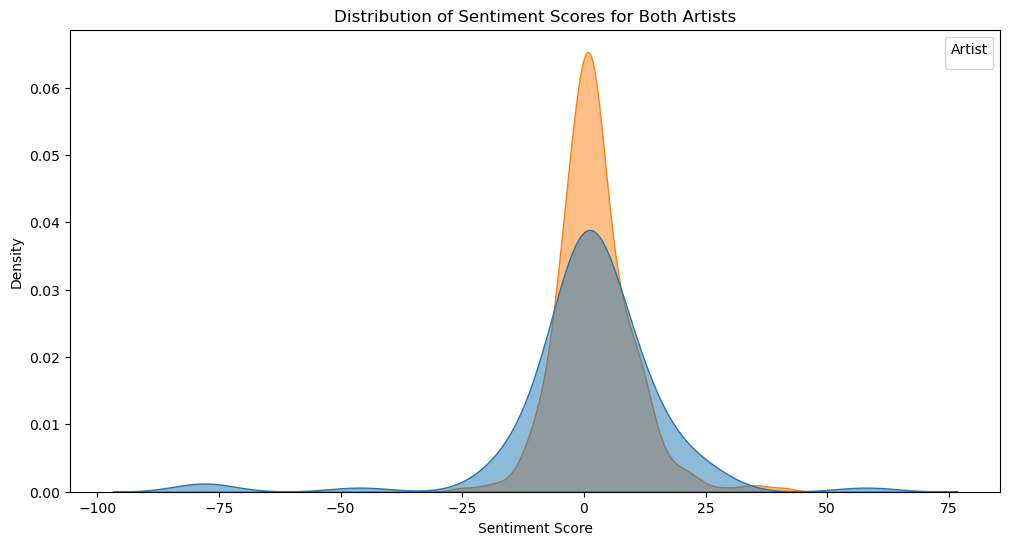

In [46]:
# Function to calculate sentiment score for a song
def calculate_sentiment_score(lyrics, sentiment_dict):
    words = lyrics.split()
    score = sum(sentiment_dict.get(word, 0) for word in words)
    return score

# Calculate sentiment scores for all songs of both artists
all_artist_sentiment_scores = defaultdict(list)
for artist, songs in lyrics_data.items():
    for song, lyrics in songs.items():
        score = calculate_sentiment_score(lyrics, sentiment_dict)
        all_artist_sentiment_scores[artist].append(score)

# Create a DataFrame for plotting
sentiment_scores_df = pd.DataFrame({
    'artist': [artist for artist in all_artist_sentiment_scores for _ in all_artist_sentiment_scores[artist]],
    'score': [score for scores in all_artist_sentiment_scores.values() for score in scores]
})

# Plot the distributions using Seaborn
plt.figure(figsize=(12, 6))
sns.kdeplot(data=sentiment_scores_df, x='score', hue='artist', fill=True, common_norm=False, alpha=0.5)
plt.title('Distribution of Sentiment Scores for Both Artists')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend(title='Artist')
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [53]:
# Define the emoji sets
positive_emojis = ["😊", "😃", "😍", "🥳", "🌟", "✨", "💖", "😇", "😎", "👍"]
negative_emojis = ["😢", "😡", "😭", "😠", "👿", "💔", "😣", "😫", "👎", "😞"]

# Associate emojis with scores
emoji_scores = {emoji: 1 for emoji in positive_emojis}
emoji_scores.update({emoji: -1 for emoji in negative_emojis})

# Function to calculate sentiment score based on emojis in a text
def calculate_emoji_sentiment(text, emoji_scores):
    score = sum(emoji_scores.get(char, 0) for char in text)
    return score

# Define the data location
twitter_folder = os.path.join(data_location, twitter_folder)

# Load Twitter descriptions for followers of each artist
def load_twitter_data(twitter_folder):
    twitter_data = {}
    
    print(f"Checking directory: {twitter_folder}")
    if not os.path.exists(twitter_folder):
        print(f"Directory does not exist: {twitter_folder}")
        return twitter_data

    for file in os.listdir(twitter_folder):
        file_path = os.path.join(twitter_folder, file)
        if os.path.isfile(file_path) and file_path.endswith('.txt'):
            print(f"Reading file: {file_path}")
            with open(file_path, 'r', encoding='utf-8') as f:
                descriptions = f.readlines()
            artist_name = os.path.splitext(file)[0]
            twitter_data[artist_name] = descriptions
        else:
            print(f"Skipping: {file_path} (not a text file)")

    return twitter_data

# Load the Twitter data
twitter_data = load_twitter_data(twitter_folder)

# Debug print: Check if data is loaded correctly
for artist, descriptions in twitter_data.items():
    print(f"Artist: {artist}, Number of Descriptions: {len(descriptions)}")

# Calculate average sentiment for each artist
artist_sentiment_scores = {}
for artist, descriptions in twitter_data.items():
    total_score = sum(calculate_emoji_sentiment(desc, emoji_scores) for desc in descriptions)
    avg_sentiment = total_score / len(descriptions) if descriptions else 0
    artist_sentiment_scores[artist] = avg_sentiment

# Print the average sentiment scores for both artists
for artist, avg_sentiment in artist_sentiment_scores.items():
    print(f"Average sentiment score for {artist}: {avg_sentiment}")

Checking directory: /Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/twitter/
Skipping: /Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/twitter/.DS_Store (not a text file)
Reading file: /Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/twitter/cher_followers_data.txt
Reading file: /Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/twitter/robynkonichiwa_followers_data.txt
Reading file: /Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/twitter/cher_followers.txt
Reading file: /Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/twitter/robynkonichiwa_followers.txt
Artist: cher_followers_data, Number of Descriptions: 3994804
Artist: robynkonichiwa_followers_data, Number of Descriptions: 358373
Artist: cher_followers, Number of Descriptions: 3995236
Artist: robynkonichiwa_followers, Number of Descriptions: 358462
Average sentiment score for cher_followers_data: 0.02119202844494999
Average sentiment score for robynkonichiwa_followers_data: 0.0138654

In [55]:
# Define the emoji sets
positive_emojis = ["😊", "😃", "😍", "🥳", "🌟", "✨", "💖", "😇", "😎", "👍"]
negative_emojis = ["😢", "😡", "😭", "😠", "👿", "💔", "😣", "😫", "👎", "😞"]

# Function to count emojis in text
def count_emojis(text, emoji_set):
    counter = Counter()
    for char in text:
        if char in emoji_set:
            counter[char] += 1
    return counter

# Define the data location
twitter_folder = os.path.join(data_location, twitter_folder)

# Load Twitter descriptions for followers of each artist
def load_twitter_data(twitter_folder):
    twitter_data = {}
    
    print(f"Checking directory: {twitter_folder}")
    if not os.path.exists(twitter_folder):
        print(f"Directory does not exist: {twitter_folder}")
        return twitter_data

    for file in os.listdir(twitter_folder):
        file_path = os.path.join(twitter_folder, file)
        if os.path.isfile(file_path) and file_path.endswith('.txt'):
            print(f"Reading file: {file_path}")
            with open(file_path, 'r', encoding='utf-8') as f:
                descriptions = f.readlines()
            artist_name = os.path.splitext(file)[0]
            twitter_data[artist_name] = descriptions
        else:
            print(f"Skipping: {file_path} (not a text file)")

    return twitter_data

# Load the Twitter data
twitter_data = load_twitter_data(twitter_folder)

# Debug print: Check if data is loaded correctly
for artist, descriptions in twitter_data.items():
    print(f"Artist: {artist}, Number of Descriptions: {len(descriptions)}")

# Calculate the most popular emojis for each artist
artist_emoji_counts = {}
for artist, descriptions in twitter_data.items():
    positive_emoji_counter = Counter()
    negative_emoji_counter = Counter()
    for desc in descriptions:
        positive_emoji_counter.update(count_emojis(desc, positive_emojis))
        negative_emoji_counter.update(count_emojis(desc, negative_emojis))
    
    # Store the most common positive and negative emojis
    artist_emoji_counts[artist] = {
        'most_common_positive': positive_emoji_counter.most_common(1),
        'most_common_negative': negative_emoji_counter.most_common(1)
    }

# Print the most popular positive and negative emojis for each artist
for artist, counts in artist_emoji_counts.items():
    print(f"Artist: {artist}")
    print(f"Most popular positive emoji: {counts['most_common_positive']}")
    print(f"Most popular negative emoji: {counts['most_common_negative']}")

Checking directory: /Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/twitter/
Skipping: /Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/twitter/.DS_Store (not a text file)
Reading file: /Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/twitter/cher_followers_data.txt
Reading file: /Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/twitter/robynkonichiwa_followers_data.txt
Reading file: /Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/twitter/cher_followers.txt
Reading file: /Users/amyou/Desktop/ADS 509/ADS 509 Module 2/M1 Results/twitter/robynkonichiwa_followers.txt
Artist: cher_followers_data, Number of Descriptions: 3994804
Artist: robynkonichiwa_followers_data, Number of Descriptions: 358373
Artist: cher_followers, Number of Descriptions: 3995236
Artist: robynkonichiwa_followers, Number of Descriptions: 358462
Artist: cher_followers_data
Most popular positive emoji: [('✨', 45846)]
Most popular negative emoji: [('💔', 2001)]
Artist: robynkonichiwa

Q: What is the average sentiment of your two artists? 

A: Average sentiment score for cher_followers_data: 0.02119202844494999
Average sentiment score for robynkonichiwa_followers_data: 0.013865441872016028 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: Artist: cher_followers_data
Most popular positive emoji: [('✨', 45846)]
Most popular negative emoji: [('💔', 2001)]

Artist: robynkonichiwa_followers_data
Most popular positive emoji: [('✨', 3217)]
Most popular negative emoji: [('💔', 72)]

The most popular positive emoji for both artists is the sparkling stars. The most popular negative emoji is the broken heart for both artists.